The following cell ensures that the Python files in the `project_dir/code/` directory can be correctly imported by this notebook

In [1]:
run = 3

In [2]:
import sys
import os
from pathlib import Path
import random

import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from tqdm import tqdm

# Add the project's `code` directory to the Python path
notebooks_dir = os.getcwd()
project_dir = os.path.dirname(notebooks_dir)
code_dir = os.path.join(project_dir, 'code')  
if code_dir not in sys.path:
    sys.path.insert(0, code_dir)

from my_utils import dict_from_disk, load_image_as_tensor
from cross_attention_dataset import CrossAttentionDataset
from probing_models import LinearProbe
from visualisation_utils import plot_masks_grid

In [3]:
DEVICE = torch.device("cpu")
# if torch.backends.mps.is_available():
#     DEVICE = torch.device("mps")
# elif torch.cuda.is_available():
#     DEVICE = torch.device("cuda")

### Load cross-attention maps from disk

In [4]:
# Set the path to the directory containing the cross-attention maps
FEATURE_DIR = Path("/Users/chrisoffner3d/Library/Mobile Documents/com~apple~CloudDocs/DL_project/ECSSD_resized/features/cross_attn")

# Filter files in directory for the cross-attention maps
cross_attn_filenames = sorted([f for f in FEATURE_DIR.glob("*.h5") if f.stem.endswith("_cross")])

# Load the cross-attention maps
cross_attn_maps = [dict_from_disk(str(f)) for f in tqdm(cross_attn_filenames)]

100%|██████████| 1000/1000 [00:05<00:00, 184.14it/s]


In [5]:
GT_DIR = Path("/Users/chrisoffner3d/Documents/Dev/ETH/DL Code/dl_project/DL Project/data/ECSSD_resized/gt")

# Load the ground truth masks for the cross-attention maps as (64, 64) tensors
base_names = map(lambda path: path.stem, cross_attn_filenames)
gt_paths = sorted([GT_DIR / f"{base_name.split('_')[0]}.png" for base_name in base_names])
gt_segmentations = [load_image_as_tensor(path, True) for path in gt_paths]

### Create a dataset and data loader from cross-attention maps

In [6]:
dataset = CrossAttentionDataset(cross_attn_maps, gt_segmentations)
data_loader = DataLoader(dataset, batch_size=1, shuffle=True)

### Train model

In [7]:
model = LinearProbe(n_timesteps=len(dataset.timesteps)).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = torch.nn.BCELoss()

In [8]:
n_epochs = 50

epoch_losses = []
for epoch in range(n_epochs):
    epoch_loss = 0
    with tqdm(data_loader, desc=f"Epoch {epoch}") as tepoch:
        for cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, gt in tepoch:
            cross_attn_8  = cross_attn_8.squeeze().to(DEVICE)
            cross_attn_16 = cross_attn_16.squeeze().to(DEVICE)
            cross_attn_32 = cross_attn_32.squeeze().to(DEVICE)
            cross_attn_64 = cross_attn_64.squeeze().to(DEVICE)
            gt = gt.to(DEVICE)

            optimizer.zero_grad()

            # Forward pass
            output = model(cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64).unsqueeze(0)
            loss = criterion(output, gt)
            epoch_loss += loss.item() / len(data_loader)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Update the progress bar description
            tepoch.set_description(f"Epoch {epoch} Loss: {epoch_loss:.4f}\t")
        
        epoch_losses.append(epoch_loss)

# Show best loss
f"Best epoch: {torch.tensor(epoch_losses).argmin().item()} with loss {min(epoch_losses)}"

Epoch 49 Loss: 0.1518	: 100%|██████████| 1000/1000 [00:06<00:00, 146.74it/s]


0.1514675423912703

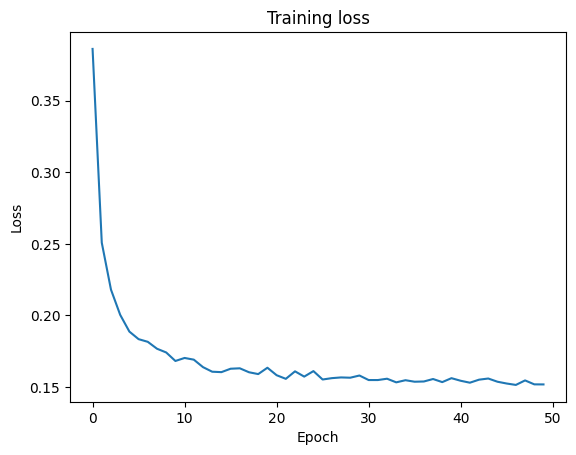

In [9]:
plt.plot(epoch_losses)
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.title("Training loss");

## Results

### Plot the model weights

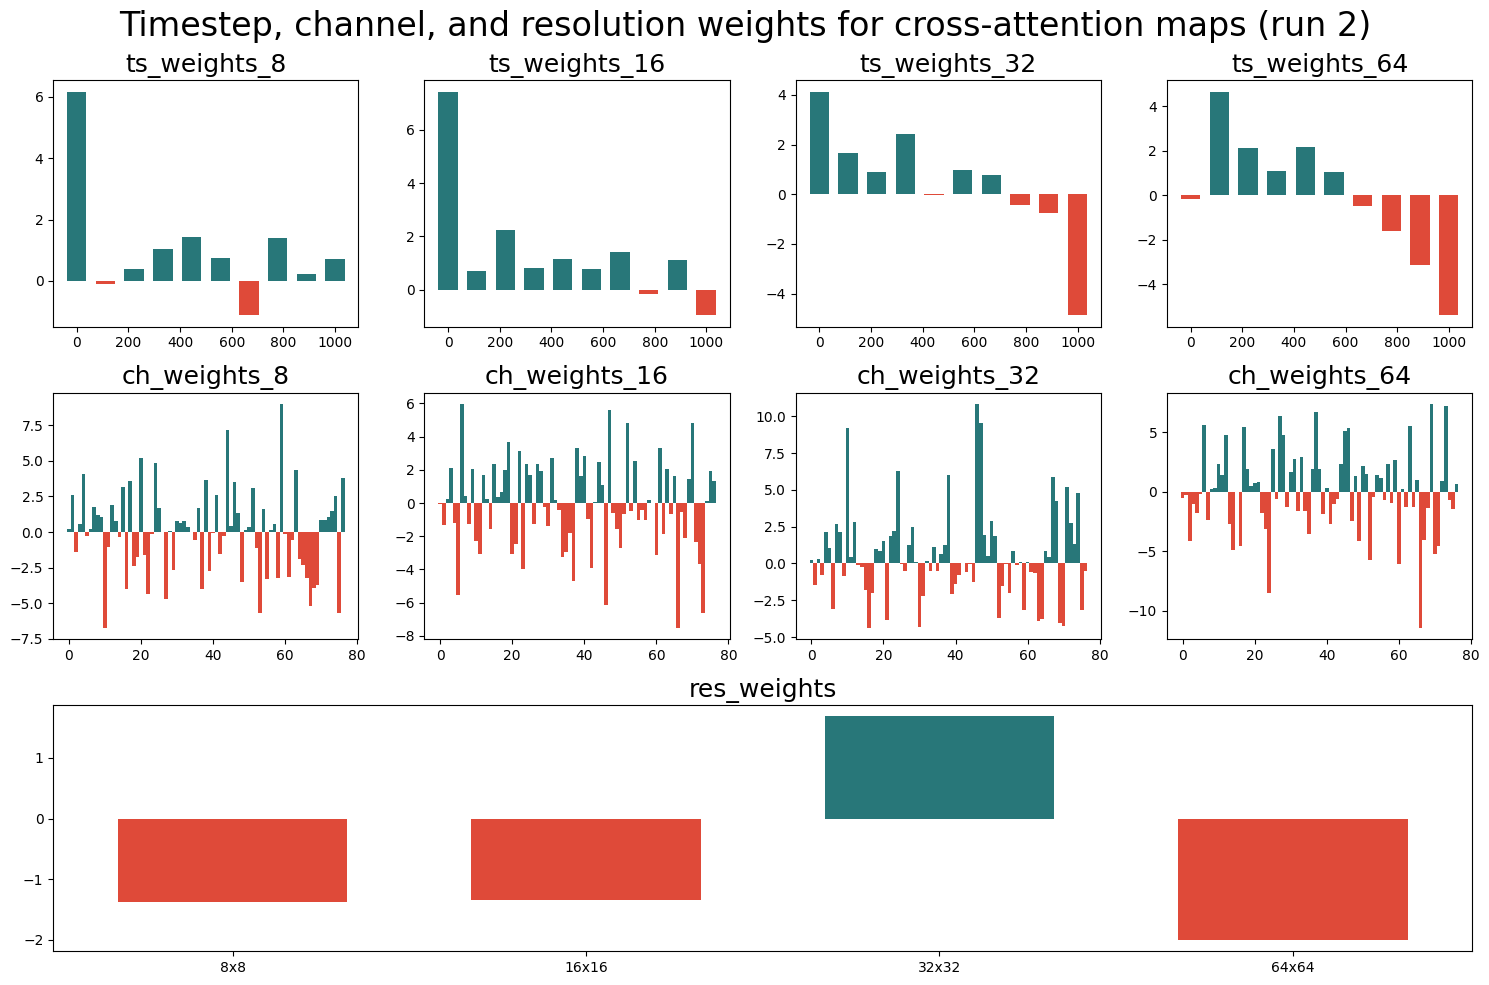

In [10]:
fig = plt.figure(figsize=(15, 10))
gs = gridspec.GridSpec(3, 4, figure=fig)

# Create axes for the first two rows
axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(4)]

# Add a wide subplot for the last row
axs.append(fig.add_subplot(gs[2, :]))

for i, (name, param) in enumerate(model.named_parameters()):
    heights = param.detach().cpu().numpy()
    color = ["#287779" if h >= 0 else "#DF4A39" for h in heights]
    width = 75 if len(param) == 10 else 1

    # Plot the resolution weights
    if len(param) < 10:
        xticks = [0, 1, 2, 3]
        xticklabels = ['8x8', '16x16', '32x32', '64x64']
        axs[i].set_xticks(xticks)
        axs[i].set_xticklabels(xticklabels)

        axs[i].bar(xticks, heights, 0.65, color=color)
        axs[i].set_title(name, fontsize=18)
        continue

    x = dataset.timesteps if len(param) == 10 else torch.arange(77)

    axs[i].bar(x, heights, width, color=color)
    axs[i].set_title(name, fontsize=18)

fig.suptitle(f"Timestep, channel, and resolution weights for cross-attention maps (run {run})", fontsize=24)
plt.tight_layout()

# Save the figure
plt.savefig(f"../plots/model_weights_run{run}.png")
plt.show()

### Plot predicted segmentation maps

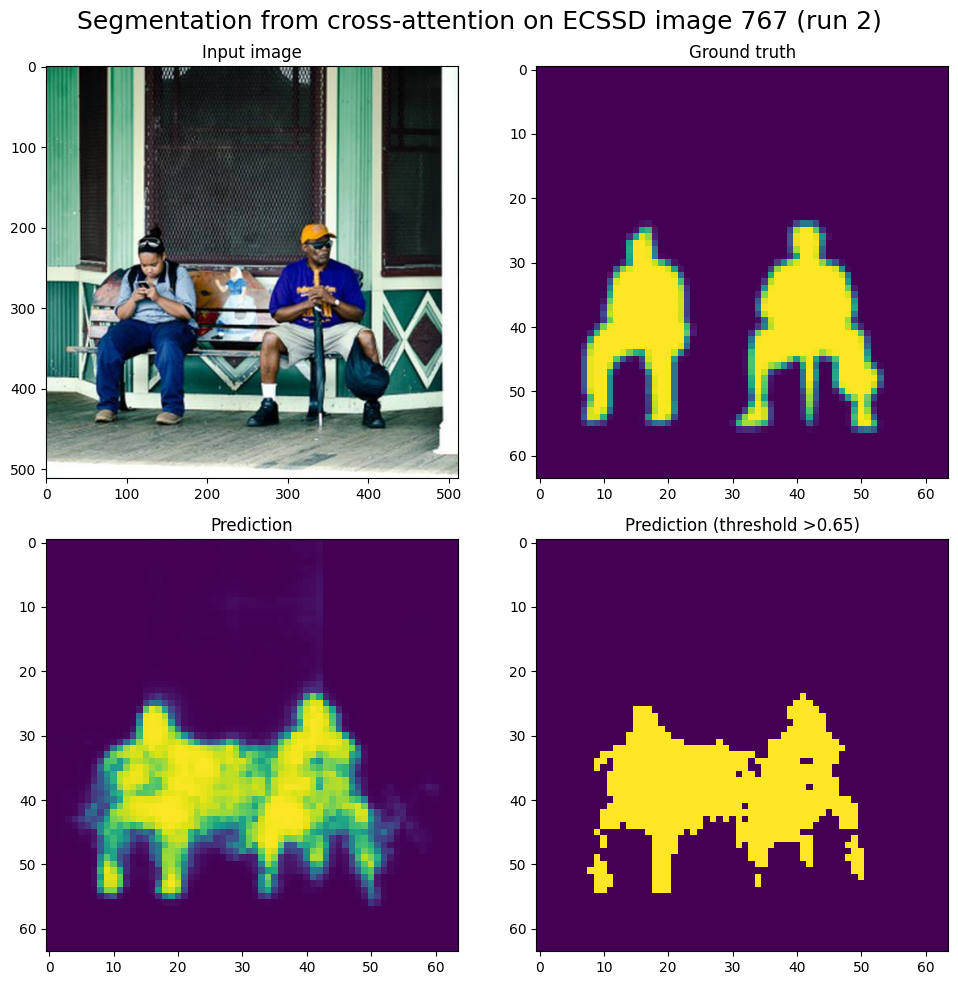

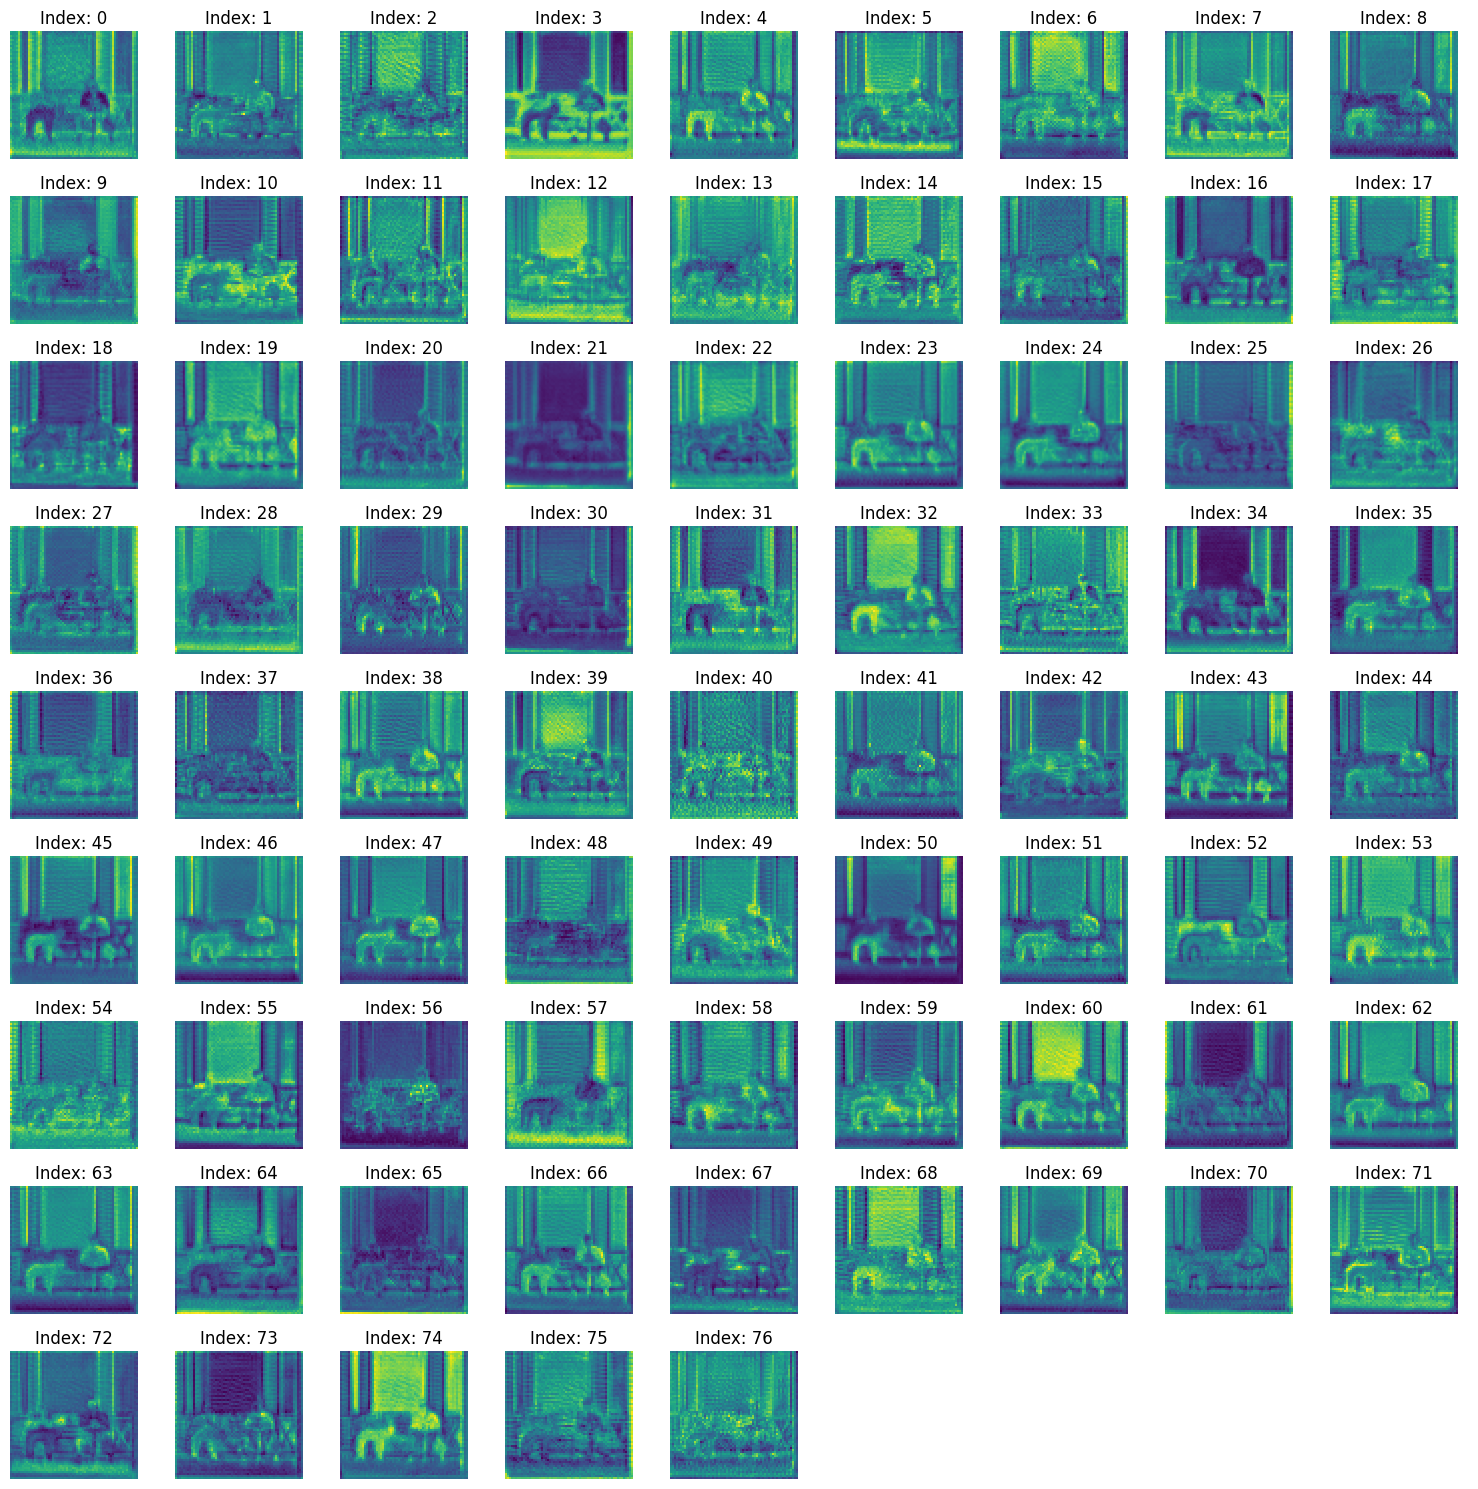

In [11]:
# Pick a random image from the dataset. Modify the index to see other images.
idx = 767 # random.randint(0, len(dataset))

# Load the image and ground truth mask
img = load_image_as_tensor(gt_paths[idx].parent.parent / "img" / (gt_paths[idx].stem + ".jpg"))
gt = load_image_as_tensor(gt_paths[idx], True)

# Get model output
with torch.no_grad():
    cross_attn_8, cross_attn_16, cross_attn_32, cross_attn_64, _ = dataset[idx]
    output = model(
        cross_attn_8,
        cross_attn_16,
        cross_attn_32,
        cross_attn_64
        ).squeeze().detach().cpu().numpy()


# Plot the input image, ground truth, and prediction
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
axs[0].imshow(img.permute(1, 2, 0))
axs[0].set_title("Input image")

axs[1].imshow(gt)
axs[1].set_title("Ground truth")

axs[2].imshow(output)
axs[2].set_title("Prediction")

threshold = 0.65
axs[3].imshow(output > threshold)
axs[3].set_title(f"Prediction (threshold >{threshold})")

fig.suptitle(f"Segmentation from cross-attention on ECSSD image {idx} (run {run})", fontsize=18)
fig.tight_layout()

# Save the figure
plt.savefig(f"../plots/ECSSD_{idx}_pre_run{run}.png")

# Plot the cross-attention maps for the image
plot_masks_grid(cross_attn_64[9])

## Reproduce and visualise aggregation of cross-attention maps

### Compute weighted sum of time steps for each resolution

In [12]:
# Collect model weights into a dictionary
weights = {}
for name, param in model.named_parameters():
    weights[name] = param.detach().cpu().numpy()

In [13]:
t_sum_8  = (cross_attn_8  * weights['ts_weights_8'][ :,  None, None, None]).sum(0)
t_sum_16 = (cross_attn_16 * weights['ts_weights_16'][:,  None, None, None]).sum(0)
t_sum_32 = (cross_attn_32 * weights['ts_weights_32'][:,  None, None, None]).sum(0)
t_sum_64 = (cross_attn_64 * weights['ts_weights_64'][:,  None, None, None]).sum(0)

### Compute weighted sum of channels for each resolution

In [14]:
ch_sum_8  = (t_sum_8  * weights['ch_weights_8'][ :, None, None]).sum(0)
ch_sum_16 = (t_sum_16 * weights['ch_weights_16'][:, None, None]).sum(0)
ch_sum_32 = (t_sum_32 * weights['ch_weights_32'][:, None, None]).sum(0)
ch_sum_64 = (t_sum_64 * weights['ch_weights_64'][:, None, None]).sum(0)

ch_sum_8  = model._upscale_to_64(ch_sum_8)
ch_sum_16 = model._upscale_to_64(ch_sum_16)
ch_sum_32 = model._upscale_to_64(ch_sum_32)

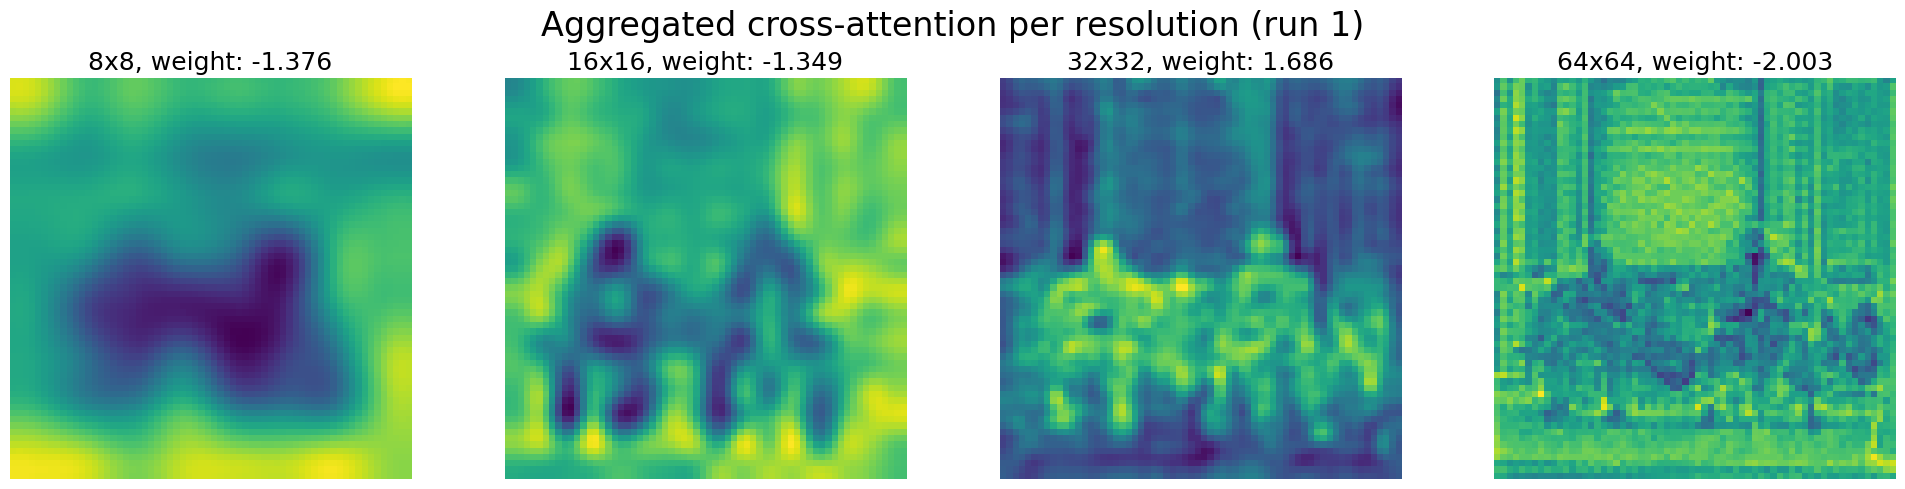

In [15]:
fig, axs = plt.subplots(1, 4, figsize=(20, 5))

axs[0].imshow(ch_sum_8)
axs[0].set_title(f"8x8, weight: {weights['res_weights'][0]:.3f}", fontsize=18)
axs[0].axis("off")

axs[1].imshow(ch_sum_16)
axs[1].set_title(f"16x16, weight: {weights['res_weights'][1]:.3f}", fontsize=18)
axs[1].axis("off")

axs[2].imshow(ch_sum_32)
axs[2].set_title(f"32x32, weight: {weights['res_weights'][2]:.3f}", fontsize=18)
axs[2].axis("off")

axs[3].imshow(ch_sum_64);
axs[3].set_title(f"64x64, weight: {weights['res_weights'][3]:.3f}", fontsize=18)
axs[3].axis("off")

fig.suptitle("Aggregated cross-attention per resolution (run 1)", fontsize=24)
fig.tight_layout(pad=1.5)

# Save the figure
plt.savefig(f"../plots/aggregated_per_res_run{run}.png")

In [16]:
!say "It is done, bitches!"